# 6.5 심리투자 법칙

알렉산더 엘더의 "주식시장에서 살아남는 심리적 투자 법칙 Trading for Living" 은 전업투자자에게 생존교본 같다. 정신분석 학자가 성공적 매매을 위한 3가지 요소 3M 을 강조한다.

1. 정신 Mind : 시장 노이즈에 휩쓸리지 않도록 해주는 원칙
1. 기법 Method : 시장 지료를 활용해 주가를 분석하고 이를 매매에 활용하는 기법
1. 자금 Money: 리스크를 거래의 일부로 포함시키는 자금 관리

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import FinanceDataReader as fdr


In [ ]:
import numpy as np
import pandas as pd

import FinanceDataReader as fdr


def krx_stocks(exchange='KRX'):
    '''
    v0.1
     - FDR 를 사용해서 KRX에 속한 주식종목 정보를 반환한다.
     - 매월 csv 파일에 저장하고 파일이 없는 경우 FDR로 다룬다.
    '''
    import time
    from pathlib import Path

    ym = time.strftime('%Y%m', time.localtime(time.time()))
    data_root = 'data'
    krx_stock_csv = Path(f'{data_root}/krx-stocks-{ym}.csv')
    if not krx_stock_csv.exists():
        df_krx = fdr.StockListing('KRX')
        df_krx.to_csv( krx_stock_csv, index=False)
        print(f'KRX {ym} Stock Listing from KRX')
    else:
        df_krx = pd.read_csv( krx_stock_csv)
        print(f'KRX {ym} Stock Listing from file: {krx_stock_csv}')
    return df_krx


def krx_symbols(names=[]):
    '''
    v0.1 
     - 주어진 names 종목이름 리스트에 대한 종목코드와 이름을 반환한다
    '''
    df_krx = krx_stocks()

    # 종목명으로 이름과 코드 찾기
    df_stocks = df_krx[df_krx['Name'].isin( names )][['Name', 'Symbol']]
    return df_stocks

## 6.5.1 시장지표

시장지표 market indicator 를 크게 세 가지로 나눌 수 있다.

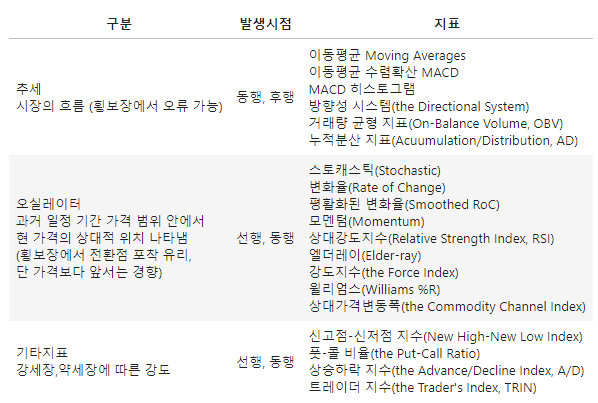

### 6.5.2 단순 이동평균

단순이동평균 Simple Moving Average, SMA 는 가장 기본적인 이동평균 지표이다. 
> 이동평균은 2차대전 당시 대공포 부대에서 적기의 이동 경로를 예측하는데서 유래되었다.

단순이동평균은 일정 기간 동안 가격을 모두 더해서 이를 가격의 개수로 나누어 평균값을 낸다. 이동평균선의 진행 방향을 보면 전반적으로 가격의 흐름을 예측할 수 있다.

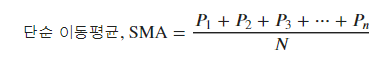

- P: 가격
- N: 가격의 개수

이동평균은 오래된 가격이 제외되고 새 가격이 추가되며 값이 달라지는데 만일 제외되는 가격이 매우 높은 가격이라면 이동평균도 하락하게 된다. 이는 오래된 과거 가격 변동으로 인한것으로 최근 가격이 하락한 의미는 아니다. 즉 단순이동평균은 과거 가격의 변동과 최근 가격 변동이 동일하게 반영되므로 최근 가격 변동이 왜곡될 가능성이 크다.

### 6.5.3 지수 이동평균


지수이동평균 Exponential Moving Average, EMA 는 최근 데이터에 가중치를 부여해 단순이동평균 보다 최근 데이터 변동을 잘 반영되도록 설계되었다.

$$
\text{지수이동평균, EMA} = P_{today} \times K + EMA_{yesterday} \times (1 - K)
$$

- K : $\frac{2}{N+1}$
- N: 지수이동평균 일수
- $P_{today}$ : 
- $EMA_{yesterday}$

단순이동평균에 비해 2가지 장점
 1. 최근 거래일에 더 많은 가중치로 최근 가격 변동에 유리
 2. 오래된 이동평균 데이터가 빠져나갈때 지수이동평균이 급락하지 않느다.


Pandas의 `ewm()` 함수로 지수이동평균을 구할 수 있다.

In [9]:
symbols = krx_symbols(['현대차'])
df = fdr.DataReader(symbols.Symbol.iloc[0], '2020-01-02')
df.head()

KRX 202110 Stock Listing from file: /Users/qkboo/Jupyter-Finance/StockPrices/marcap/data/krx-stocks-202110.csv


,Open,High,Low,Close,Volume,Change
Date,,,,,,
2020-01-02,121000,121000,118000,118000,556532,-0.020747
2020-01-03,118500,119000,115000,116000,1145187,-0.016949
2020-01-06,116000,117000,115500,116000,334574,0.000000
2020-01-07,116500,117000,115500,115500,674196,-0.004310
2020-01-08,115000,115500,111500,112000,1044825,-0.030303


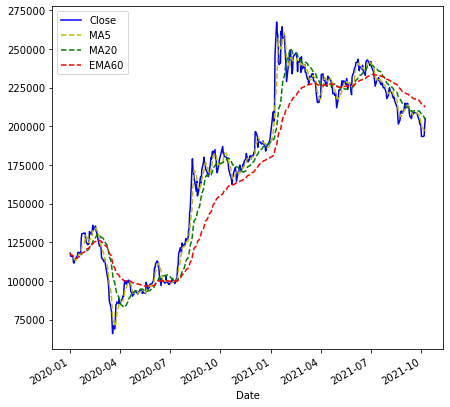

In [14]:
df['MA5'] = df.Close.rolling(window=5).mean()
df['MA20'] = df.Close.rolling(window=20).mean()
df['EMA60'] = df.Close.ewm(span=60).mean()   # 종가의 12주 지수 이동평균

df[['Close', 'MA5', 'MA20', 'EMA60']].plot(figsize=(7,7),
                                          style=['b', 'y--', 'g--', 'r--'])
plt.show()

### 6.5.4 이동평균 수렴확산(MACD)

제럴드 아펠은 세 가지 지수 이동평균선을 이용해 ***이동평균 수렴확산(Moving Average Convergence Divergence, MACD)*** 을 개발했다.

실제 MACD 차트는 *2가지 선으로 표시되는데 하나는 MACD 실선이고 다른 하나는 신호선 점선*이다. 이 두 선의 교차점에서 매매 신호가 발생한다. (1) <u>MACD 선은 종가의 12일 지수이동평균 선에서 26일 지수이동평균선을 뺀것으로 가격 변화에 상대적으로 빨리 반응</u>한다. 한편 (2) <u>신호선은 MACD의 9일 지수이동평균선을 구한것으로 MACD 선을 평활화 한것으로 가격 변화에 상대적으로 늦게 반응</u>한다.

빠른 MACD선이 신호선을 상향 돌파하는 것은 매수세가 시장을 주도한다는 것으로 매수 과점이고, 반대로 빠른 MACD 선이 늦은 신호선을 하향 돌파하면 매도 관점이다.

### 6.5.5 MACD 히스토그램

MACD 히스토그람은 원래 MACD보다 매수/매도 상태를 더 잘 표현한다. 매수,매도의 비중을 표현하며 강세, 약세를 보여준다.

$$
\text{MACD 히스토그램} = \text{MACD선} - \text{신호선}
$$

### 6.5.6 스토캐스틱

스토캐스틱 Stochastic은 조지 레인에 의해서 대중화된 오실레이터로서 **지난 n일 동안 거래 범위에서 현재 가격 위치를 백분율로 나타낸다**. <u>14일 스토캐스틱이 70이면 지난 14일간 거래에서 최저점과 최고점 사이 70%에 위치해 있다</u>는 의미이다. 일반적으로 80 이상은 과매수 상태를 나타내고 20이하는 과매도 상태를 나타낸다.



스토캐스틱은 2개 선으로 이루어져 빠른 선은 %K, 느린 선은 %D이다. 일반적으로 %K의 기간은 14일로 정하지만 알렉산더 엘더는 짧은 반전을 잡아내기 용이한 5일로 설정한다. (반면 기간이 길면 중요 변곡점을 잡아내는데 용이하다)

빠른선 %K를 다음 같이 구한다

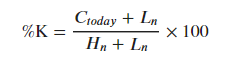

 - $C_{today}$ : 오늘의 종
 - $H_n$ : 선정된 기간의 고점
 - $L_n$ : 선정된 기간의 저점
 - $n$ : 트레이더에 선정된 기간

느린선 %D 는 빠른선 %K를 평활화 해서 얻는다. 일반적으로 3일을 사용한다.

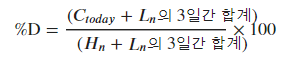

따라서 스토캐스틱은 장시 추세 추종형 지표와 결합해 사용해야 한다. 보통 알렉산더 엘더의 삼중창 매매 시스템 Triple Screen Trading system은 MACD 히스토그램 주간 추세가 상승하고 있을 때 일간 스토캐스틱에서 매수 신호를 취하도록 설계 되었다.

# 6.6 삼중창 매매 시스템

알렉산더 엘더가 개발한 삼중차 매매 시스템은 86년 4월 "퓨처스 매거긴" 에 실리며 대중에 공개되었다. 삼중차 시스템은 추세 추종과 역추세 매매법을 함께 사용하며 세 단계의 창screen을 거쳐 더 정확한 매매 시점을 찾도록 구성되어 있다.

같은 시장이라도 지표들이 내는 신호는 다를 수 있다. 예를 들어 시장이 상승 추세일때 추세 추종형 지표는 일반적으로 매수 신호를 주지만, 오실레이터는 과매수 상태로 판단해 매도 신호를 준다. 따라서 삼중차 매매 시스템은 한 가지 지표만 사용했을 때의 단점을 보와하고자 추세 추종형 지표와 오실레이터를 적절히 결합해 사용한다.

## 6.6.1 첫번째 창 - 시장 조류

매수, 매도, 관망 세 가지 거래 자세에서, 삼중창의 첫 번째 창 First Screen 을 이용하면 한 선택지를 제거할 수 있다. 시장이 상승 추세인지 하락 추세인지 판단해 상승시 매수 혹은 관망하고, 하락 추세에는 매도하거나 관망한다.

첫 번째 창은 ***시장 조류 Market Tide*** 로 장기 차트를 분석하는 것이다. 보통 매매하는 시간 단위보다 한 단 계 긴 단위 차트를 이용해 분석하는 것이다. 예를 들어 일간 차트로 매매한 다면 이보다 긴 주간 차트로 추세를 분석하는 것이다. 또는 5분 차트로 매매하는 것을 30분 봉 으로 추세를 분석해야 한다. 

In [15]:
symbols = krx_symbols(['엔씨소프트'])

dfstock = fdr.DataReader(symbols.Symbol.iloc[0], '2017-01-02', '2018-12-31')
dfstock.head()

KRX 202110 Stock Listing from file: /Users/qkboo/Jupyter-Finance/StockPrices/marcap/data/krx-stocks-202110.csv


,Open,High,Low,Close,Volume,Change
Date,,,,,,
2017-01-02,246000,248500,241000,248000,84051,0.002020
2017-01-03,249000,260500,249000,259000,160386,0.044355
2017-01-04,258000,263000,256500,260000,105440,0.003861
2017-01-05,260000,263000,259000,261000,67168,0.003846
2017-01-06,259000,261500,254500,260500,79682,-0.001916


In [16]:
df = dfstock.copy()

봉 차트는 mplfinance
> 이전 버전은 mpl_finance 모듈의 candlestick2_ohlc 함수를 이용하면 바로 그릴 수 있다. 

```sh
(base)$ pip install --upgrade mplfinance
```

In [20]:
import matplotlib.dates as mdates
from mpl_finance import candlestick_ohlc

ema60 = df.Close.ewm(span=60).mean()   # 종가의 12주 지수 이동평균
ema130 = df.Close.ewm(span=130).mean() # 종가의 26주 지수 이동평균
macd = ema60 - ema130                  # MACD선
signal = macd.ewm(span=45).mean()      # 신호선(MACD의 9주 지수 이동평균)
macdhist = macd - signal               # MACD 히스토그램

df = df.assign(ema130=ema130, ema60=ema60, macd=macd, signal=signal,
    macdhist=macdhist).dropna() 
df['Number'] = df.index.map(mdates.date2num)  # ⑥
ohlc = df[['Number', 'Open','High','Low','Close']]#df[['number','open','high','low','close']]

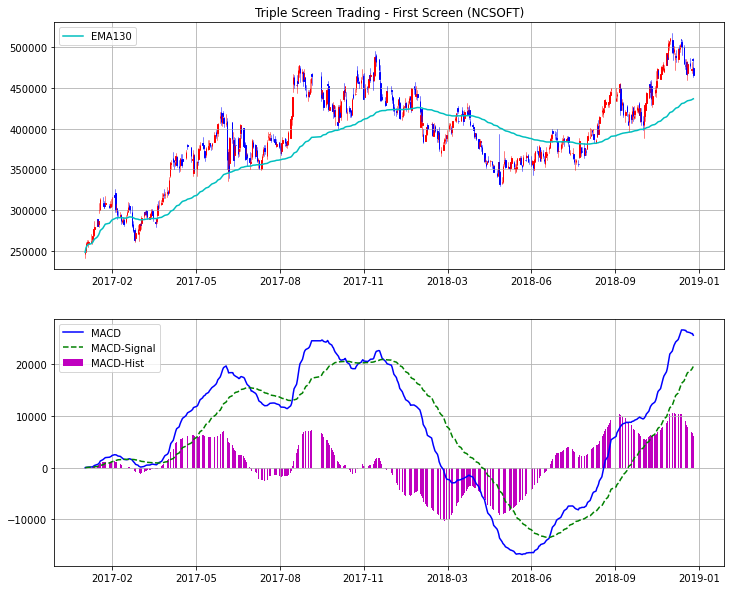

In [23]:
plt.figure(figsize=(12, 10))
p1 = plt.subplot(2, 1, 1)
plt.title('Triple Screen Trading - First Screen (NCSOFT)')
plt.grid(True)
candlestick_ohlc(p1, ohlc.values, width=.6, colorup='red', 
    colordown='blue')  # ⑦
p1.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.plot(df.Number, df['ema130'], color='c', label='EMA130')
plt.legend(loc='best')

p2 = plt.subplot(2, 1, 2)
plt.grid(True)
p2.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.bar(df.Number, df['macdhist'], color='m', label='MACD-Hist')
plt.plot(df.Number, df['macd'], color='b', label='MACD')
plt.plot(df.Number, df['signal'], 'g--', label='MACD-Signal')
plt.legend(loc='best')
plt.show()


삼중창 매매시스템의 첫 번째 창으로 시장의 장기 추세를 분석하기 위해서 26주 (130일) 이동평균과 주간 MACD 를 표시하고 있다. 26주는 연간 거래일의 절반에 해당한다. 26주 이동평균 대신 일간 지수 이동평균을 130일로 설정해도 된다.

초기 삼중창은 시장의 장기 추세를 파악하는데 MACD 히스토그램의 기울기를 이용했는데 이는 MACD 히스토그램의 두 봉 높이를 비교해 파악할 수 있다. 알렉산더 엘더의 저수 "나의 트레이딩 룸으로 오라" 에서도 최근에는 26주 지수이동평균을 사용한다고 한다.

필자가 테스트해봐도 주간 MACD 히스토그램을 사용시 불필요한 매수/매도 신호가 자주 발생했다, 지금은 26주 지수이동평균 (EMA 130)을 주가 추세추종 지표로 사용하고 있다. 그래서 삼중창 첫번째 창에서는 EMA 130 그래프가 오를 때 시장에 참여하면 된다.

## 6.6.2 두 번째 창 - 시장파도

두번째 창 second screen 에서는 첫번째 창의 추세 방향과 역행하는 파도 market wave를 파악하는데 오실레이터를 활용한다. 오실레이터는 시장이 하락할 때 매수 기회를 제공하고 시장이 상승 때 매도 기회를 제공한다. 즉 주봉 추세가 상승 할 때 일봉 추세가 하락하면 매수 기회로 본다.

"주식시장에서 살아남는 심리투자 법칙" 에서는 주간 MACD 히스토그램이 상승할 때 스토캐스틱이 30 아래로 내려가면 매수하고, 주간 MACD 히스토그램이 하락할 때 스토캐스틱이 70 위로 올라가면 매도하라고 나와 있다. 

하지만 주간 히스토그램 보다 EMA 130 지수 이동평균의 신뢰가 높으므로 이것을 스토캐스틱과 함께 사용한다.

In [24]:
df = dfstock.copy()

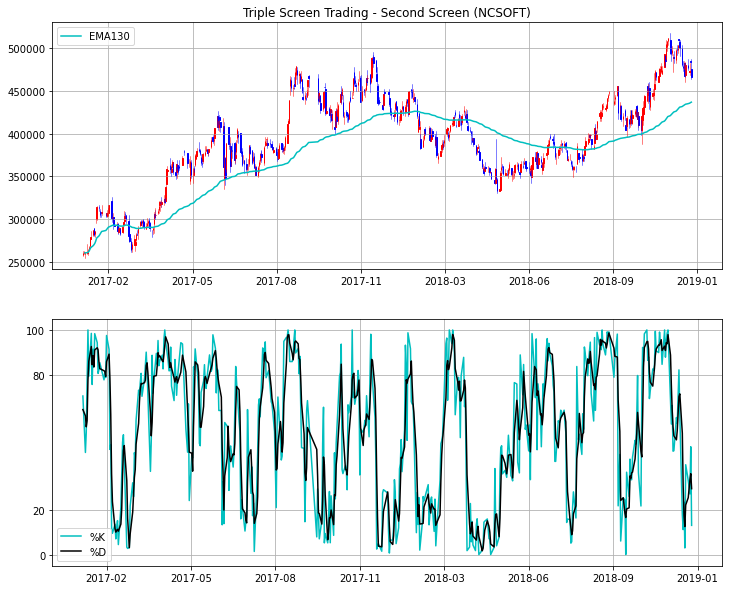

In [27]:
ema60 = df.Close.ewm(span=60).mean()
ema130 = df.Close.ewm(span=130).mean() 
macd = ema60 - ema130
signal = macd.ewm(span=45).mean() 
macdhist = macd - signal

df = df.assign(ema130=ema130, ema60=ema60, macd=macd, signal=signal,
    macdhist=macdhist).dropna()
df['Number'] = df.index.map(mdates.date2num)
ohlc = df[['Number','Open','High','Low','Close']]

ndays_high = df.High.rolling(window=14, min_periods=1).max()      # ①
ndays_low = df.Low.rolling(window=14, min_periods=1).min()        # ②
fast_k = (df.Close - ndays_low) / (ndays_high - ndays_low) * 100  # ③
slow_d= fast_k.rolling(window=3).mean()                           # ④
df = df.assign(fast_k=fast_k, slow_d=slow_d).dropna()             # ⑤

plt.figure(figsize=(12, 10))
p1 = plt.subplot(2, 1, 1)
plt.title('Triple Screen Trading - Second Screen (NCSOFT)')
plt.grid(True)
candlestick_ohlc(p1, ohlc.values, width=.6, colorup='red', colordown='blue')
p1.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.plot(df.Number, df['ema130'], color='c', label='EMA130')
plt.legend(loc='best')
p1 = plt.subplot(2, 1, 2)
plt.grid(True)
p1.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.plot(df.Number, df['fast_k'], color='c', label='%K')
plt.plot(df.Number, df['slow_d'], color='k', label='%D')
plt.yticks([0, 20, 80, 100]) # ⑥
plt.legend(loc='best')
plt.show()


EMA 130일 지수이동평균선하고 아래에 스토캐스틱을 표시하고 있다. 스토캐스틱의 빠른 선 %K와 느린 선 %D 가 있다. %K 대신 %D를 사용할 경우 더 적은 신호를 만들어 내기 때문에 그만큼 확실한 신호로 볼 수 있다.

삼중창 매매시스템의 두 번째 창인 시장파도는 EMA130 선이 상승하고 있을 때 스토캐스틱이 30 이하로 내려가면 매수 기회로 보고, EMA 130이 하락하고 있을 때 스토캐스틱이 70 위로 올라가면 매도 기회로 본다.

## 6.6.3 세 번째 창 - 진입기술

세 번째 창은 차트가 지표를 필요로 하지 않는다. 단지 첫 번째 창과 두 번째 창이 동시에 매매 신호를 냈을 때 진입 시점을 찾는 시점 Entry technique 만 있다. 
 - 주간 추세가 상승하면 추적 매수 스톱 Trading Buy Stop 기법을 사용해 가격 변동에 따라 주문 수준을 수정한다. 
 - 하락 추세에서는 추적 매수 스텁 기법을 사용해 가격 변동에 따라 주문 수준을 수정한다.
 
주간 추세가 상승시 일간 오실레이터가 하락하며 매수 신호가 발생하면 전일 고점 보다 한 틱 위에서 매수 주문을 낸다. 이를 추적 매수 스톱이라고 한다. 만약 주간 추세대로 가격이 계속 상승해 *전일 고점을 톨파하는 순간 Intraday Breakout*  매수 주문이 체결 될 것이다. 매수 주문이 체결되면 전일의 저가나 그 전일의 저가 중 낮은 가격 보다 한 틱 아래에 매도 주문을 걸어 놓으므로 손실을 막을 수 있다.

만약 가격이 하락하면 매수 스톱은 체결되지 않을 것이다. 매수 주문이 체결되지 않으면 다시 전일 고점 1틱 위가지 매수 주문의 수준을 낮추도록 한다. 주간 추세가 반대 방향으로 움직이거나 매수 신호가 취소 될 때 까지 매일 매수 스툽을 낮추면서 주문을 걸어 놓는다. 

다음은 주간 추세와 일간 오실레이터의 변도에 따라 주문을 내는 테이블 이다.

주간추세 | 일간 오실레이터 | 행동 | 주문
-------- | ------------- | ------ | -------------
상승 | 상승 | 관망 | 
상승 | 하락 | 매수 | 추적 매수 스톱
하락 | 하락 | 관망 | 
하락 | 상승 | 매도 | 추적 매도 스톱

## 6.6.4 전체

아래는 두 번째 창에 오실레이터로 스토캐스틱 %D를 사용하고 기준 포인트로 70, 30 대신 80, 20을 사용해 더 확실한 신호를 잡도록 했다. 즉 EMA130 지수가 상승하고 %D가 20 아래일 때 매수하고, EMA130 지수가 하락하고 %D가 80 위로 올라갈 때 매도하도록 구현한 코드이다.

In [28]:
df = dfstock.copy()

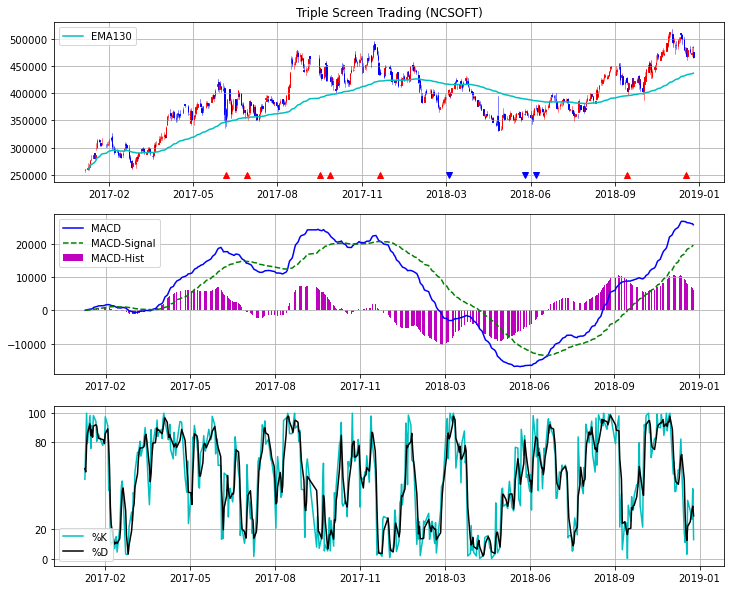

In [31]:
import matplotlib.dates as mdates
from mpl_finance import candlestick_ohlc

ema60 = df.Close.ewm(span=60).mean()
ema130 = df.Close.ewm(span=130).mean()
macd = ema60 - ema130
signal = macd.ewm(span=45).mean()
macdhist = macd - signal
df = df.assign(ema130=ema130, ema60=ema60, macd=macd, signal=signal, macdhist=macdhist).dropna()

df['Number'] = df.index.map(mdates.date2num)
ohlc = df[['Number','Open','High','Low','Close']]

ndays_high = df.High.rolling(window=14, min_periods=1).max()
ndays_low = df.Low.rolling(window=14, min_periods=1).min()

fast_k = (df.Close - ndays_low) / (ndays_high - ndays_low) * 100
slow_d = fast_k.rolling(window=3).mean()
df = df.assign(fast_k=fast_k, slow_d=slow_d).dropna()

plt.figure(figsize=(12, 10))
p1 = plt.subplot(3, 1, 1)
plt.title('Triple Screen Trading (NCSOFT)')
plt.grid(True)
candlestick_ohlc(p1, ohlc.values, width=.6, colorup='red', colordown='blue')
p1.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.plot(df.Number, df['ema130'], color='c', label='EMA130')
for i in range(1, len(df.Close)):
    if df.ema130.values[i-1] < df.ema130.values[i] and \
        df.slow_d.values[i-1] >= 20 and df.slow_d.values[i] < 20:
        plt.plot(df.Number.values[i], 250000, 'r^') 
    elif df.ema130.values[i-1] > df.ema130.values[i] and \
        df.slow_d.values[i-1] <= 80 and df.slow_d.values[i] > 80:
        plt.plot(df.Number.values[i], 250000, 'bv') 
plt.legend(loc='best')

p2 = plt.subplot(3, 1, 2)
plt.grid(True)
p2.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.bar(df.Number, df['macdhist'], color='m', label='MACD-Hist')
plt.plot(df.Number, df['macd'], color='b', label='MACD')
plt.plot(df.Number, df['signal'], 'g--', label='MACD-Signal')
plt.legend(loc='best')

p3 = plt.subplot(3, 1, 3)
plt.grid(True)
p3.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.plot(df.Number, df['fast_k'], color='c', label='%K')
plt.plot(df.Number, df['slow_d'], color='k', label='%D')
plt.yticks([0, 20, 80, 100])
plt.legend(loc='best')
plt.show()
